# Create GOES image tiles

- Authors: Marc Shapiro
- Date: 2023-04-14
- `pycontrails`: v0.40.1

Use the Microsoft Planetary computer to create webmap tiles from GOES imagery using `rasterio`.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/contrailcirrus/2023-04-pycontrails-workshop/blob/main/notebooks/03-GOES-tilesipynb)

In [ ]:
# install dependencies
!pip install numpy
!pip install planetary-computer
!pip install pystac-client
!pip install rio_tiler
!pip install requests
!pip install Pillow

In [1]:
import math
import io

import numpy as np
import pandas as pd
from pystac_client import Client
import planetary_computer
from PIL import Image as PILImage
from rio_tiler.io import COGReader, rasterio
import requests

# Query for Cloud-Optimized GeoTiff

The [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/) has a [STAC](https://stacspec.org/en/) interface for GEOS imagery.

STAC supports indexing and querying of spatiotemporal assets.

In [2]:
# Open the STAC catalog
STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1/"
catalog = Client.open(STAC_URL)

# Query for GOES
COLLECTION = "goes-cmi"
QUERY = {"goes:image-type": {"eq": "FULL DISK"}}

In [3]:
def download_cog(href: str, filepath: str) -> None:
    """Download COG from url to local filepath.

    Parameters
    ----------
    href : str
        Remote COG url
    filepath : str
        Local filepath
    """
    r = requests.get(href)

    with open(filepath, "wb") as f:
        f.write(r.content)

In [4]:
# Input start/end time to search for imagery
start_time = pd.Timestamp("2020-01-01 12:00:00")
end_time = pd.Timestamp("2020-01-01 12:10:00")

date_range = [
    start_time.strftime("%Y-%m-%dT%H:%M:%S%zZ"),
    end_time.strftime("%Y-%m-%dT%H:%M:%S%zZ"),
]

# Loads the first item returned from search
search = catalog.search(collections=[COLLECTION], datetime=date_range, query=QUERY)

In [5]:
# download bands of interest from assets returned from query
for item in search.get_items():
    item = planetary_computer.sign(item)

    # download assets for times
    download_cog(item.assets["C11_2km"].href, f"data/goes/cog/{item.id}-C11_2km.tif")
    download_cog(item.assets["C14_2km"].href, f"data/goes/cog/{item.id}-C14_2km.tif")
    download_cog(item.assets["C15_2km"].href, f"data/goes/cog/{item.id}-C15_2km.tif")

## Create GOES tiles

In [6]:
def clip_and_scale(arr: np.ndarray, low: float, high: float) -> np.ndarray:
    """Clip array and rescale image array to interval [0, 1].

    Array is first clipped to the interval [low, high] and then linearly rescaled
    to the interval [0, 1] so that:

        low -> 0
        high -> 1

    Parameters
    ----------
    arr : np.ndarray
        Array to clip and scale.
    low : float
        Lower clipping bound.
    high : float
        Upper clipping bound.

    Returns
    -------
    np.ndarray
        Clipped and scaled array.
    """
    return (arr.clip(low, high) - low) / (high - low)


def rescale_cog(cog: rasterio.Reader, img_array: np.ndarray):
    """Rescale image array according to COG metadata "scale" and "offset".

    Parameters
    ----------
    cog : rasterio.Reader
        COG opened with `COGReader`
    img_array : np.ndarray
        Image array

    Returns
    -------
    np.ndarray
        Image scaled by COG metadata "scale" and "offset".
    """
    info = cog.info()

    arr = img_array.astype(np.float64)
    arr[arr == -1] = np.nan

    # rescale image
    arr_scaled = arr * info["scale"] + info["offset"]

    # reset nan pixels to 0 after scaling
    arr_scaled[np.isnan(arr_scaled)] = 0

    return arr_scaled


def build_tile(
    z: int,
    x: int,
    y: int,
    c11cog: rasterio.Reader,
    c14cog: rasterio.Reader,
    c15cog: rasterio.Reader,
    filename: str = None,
) -> PILImage:
    """Build ASH color scheme tile for tile coordiantes

    Parameters
    ----------
    z, x, y : int
        Tile coordinates
    c11cog, c11cog, c11cog : rasterio.Reader
        COG GOES files
    filename : str
        Output (png)

    Returns
    -------
    PILImage
        Tile image
    """
    z = int(z)
    x = int(x)
    y = int(y)

    c11tile = c11cog.tile(x, y, z)
    c14tile = c14cog.tile(x, y, z)
    c15tile = c15cog.tile(x, y, z)

    c11 = rescale_cog(c11cog, c11tile.data_as_image())
    c14 = rescale_cog(c14cog, c14tile.data_as_image())
    c15 = rescale_cog(c15cog, c15tile.data_as_image())

    red = c15 - c14
    green = c14 - c11
    blue = c14

    # set default alpha (this was set to 0.5 in notebook, but 1 here)
    alpha = np.full(c11.shape, 1)
    alpha[c11 == 0] = 0

    # See colostate pdf for slightly wider values
    red = clip_and_scale(red, -4, 2)
    green = clip_and_scale(green, -4, 5)
    blue = clip_and_scale(blue, 243, 303)

    rgba = np.dstack([red, green, blue, alpha])
    rgba8 = (255 * rgba).astype(np.uint8)
    im = PILImage.fromarray(rgba8, mode="RGBA")

    if filename:
        im.save(filename, format="PNG")

    return im


def tile_to_bbox(tile_z, tile_x, tile_y) -> list[float]:
    """Convert tile coordinates to bounding box.

    Parameters
    ----------
    tile_z, tile_x, tile_y : int
        Tile coordinates

    Returns
    -------
    list[float]
        [W, S, E, N]
    """
    z = int(tile_z)
    x = int(tile_x)
    y = int(tile_y)

    n = 2.0**z

    left_lon = x / n * 360.0 - 180.0
    top_lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * y / n)))
    top_lat = math.degrees(top_lat_rad)

    right_lon = (x + 1) / n * 360.0 - 180.0
    bottom_lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * (y + 1) / n)))
    bottom_lat = math.degrees(bottom_lat_rad)

    return [left_lon, bottom_lat, right_lon, top_lat]

In [7]:
# make tiles directory
!mkdir -p data/goes/tiles

# open a single item
item_id = "OR_ABI-L2-F-M6_G16_s20200011200218"

# or iterate through search
# for item in search.get_items():
#     item = planetary_computer.sign(item)
#     item_id = item.id

c11cog = COGReader(input=f"data/goes/cog/{item_id}-C11_2km.tif")
c14cog = COGReader(input=f"data/goes/cog/{item_id}-C14_2km.tif")
c15cog = COGReader(input=f"data/goes/cog/{item_id}-C15_2km.tif")

[-112.5, 0.0, -90.0, 21.943045533438177]


/opt/homebrew/Caskroom/miniforge/base/envs/data-staging/lib/python3.9/site-packages/rio_tiler/io/base.py:66: UserWarning: Transformation to geographic CRS returned invalid values, will default to (-180.0, -90.0, 180.0, 90.0).
  warnings.warn(


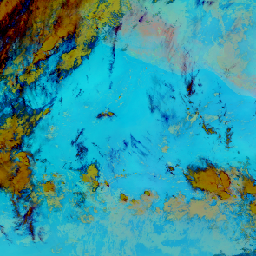

In [8]:
z, x, y = (4, 3, 7)
print(tile_to_bbox(z, x, y))
tile = build_tile(
    z, x, y, c11cog, c14cog, c15cog, f"data/goes/tiles/z{z}_x{x}_y{y}.png"
)
tile